Accuracy: 0.7778
AUC Score: 0.9259
Classification Report:
               precision    recall  f1-score   support

        Fake       0.73      0.89      0.80         9
        Real       0.86      0.67      0.75         9

    accuracy                           0.78        18
   macro avg       0.79      0.78      0.78        18
weighted avg       0.79      0.78      0.77        18



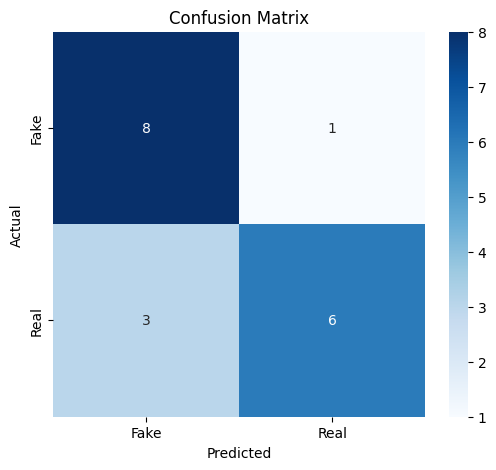

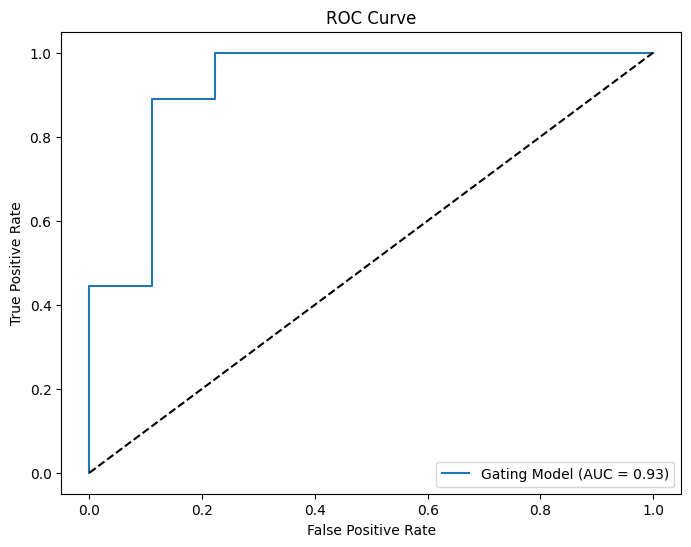

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve

# Load CSV file
data = pd.read_csv("singfake_bilibili_audio_features.csv")

target = "bonafide_or_spoof"

# Define numerical features
numerical_features = ["views", "likes", "comments", "subscribers",
                      "num_channels", "sample_width", "frame_rate",
                      "num_frames", "audio_time"]

# Remove non-informative features
data = data.drop(columns=["set", "language", "singer", "title", "url", "user_id", "username"], errors='ignore')

# Handle missing values
data = data.dropna(subset=numerical_features + [target])

# Log transformation for skewed features
for col in ["views", "likes", "comments", "subscribers"]:
    data[col] = np.log1p(data[col])

# Feature Selection & Scaling
constant_filter = VarianceThreshold(threshold=0)
data_filtered = constant_filter.fit_transform(data[numerical_features])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Select best features
k = min(10, data_scaled.shape[1])
selector = SelectKBest(f_classif, k=k)
X_selected = selector.fit_transform(data_scaled, data[target])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, data[target], test_size=0.3, random_state=42, stratify=data[target])

# Define expert models
experts = {
    "Neural Network": MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=5000, learning_rate_init=0.001, solver="adam", early_stopping=True, batch_size=4, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=8, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=500, learning_rate=0.02, max_depth=5, min_samples_split=3, random_state=42),
    "Support Vector Machine": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42)
}

# Train experts and collect their predictions for training the gating network
expert_predictions_train = []
expert_predictions_test = []

for name, model in experts.items():
    model.fit(X_train, y_train)
    y_prob_train = model.predict_proba(X_train)[:, 1]  # Probability estimates for training data
    y_prob_test = model.predict_proba(X_test)[:, 1]  # Probability estimates for test data
    expert_predictions_train.append(y_prob_train)
    expert_predictions_test.append(y_prob_test)

# Stack predictions as new feature set for the gating network
X_train_moe = np.column_stack(expert_predictions_train)
X_test_moe = np.column_stack(expert_predictions_test)

# Train logistic regression as the gating network
gating_model = LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000)
gating_model.fit(X_train_moe, y_train)

# Predict using the gating model
y_pred = gating_model.predict(X_test_moe)
y_prob = gating_model.predict_proba(X_test_moe)[:, 1]

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["Fake", "Real"])
auc_score = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("Classification Report:\n", classification_rep)

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve Plot
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"Gating Model (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


This code implements a Mixture of Experts (MoE) model to classify bonafide and spoofed audio using the SingFake dataset. It preprocesses data by removing non-informative features, handling missing values, applying log transformations, and selecting the most relevant features. Four expert models—Neural Network, Random Forest, Gradient Boosting, and SVM—are trained separately, and their probability outputs are collected. A Logistic Regression model acts as the gating network, learning how to combine expert predictions. The final model is evaluated using accuracy, AUC score, and classification metrics, with visualizations including a confusion matrix and ROC curve.


The MoE model demonstrates strong potential with its high AUC score and decent accuracy. However, optimizing recall for the real class and precision for the fake class could further enhance performance. The preprocessing and ensemble approach are effective, but fine-tuning and expanding the evaluation dataset may yield even better results.